In [204]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
pd.set_option('display.max_rows', 500)
import holidays

INPUT_PATH = "../data/external/acidentes*.csv"
OUTPUT_PATH = "../data/processed/"
VERSION = "v1"

**Sumários**<a id='toc0_'></a>    
- [Segmentação de Dados](#toc1_1_)    
  - [Ingestão de Alcool](#toc1_1_1_)    
  - [Sexo](#toc1_1_2_)    
  - [Tipo Envolvido](#toc1_1_3_)    
  - [Idade](#toc1_1_4_)    
- [Enriquecimento](#toc1_2_)    
  - [Feriados](#toc1_2_1_)   
- [Transformação](#toc1_3_)    
  - [Condição metereológica](#toc1_3_1_)    
  - [Feriados](#toc1_3_2_)    
  - [Fase do Dia](#toc1_3_3_)    
  - [Tipo da estrada](#toc1_3_4_)    
  - [Idade](#toc1_3_5_)    
  - [Grupo de Idade](#toc1_3_6_)    
  - [Balanceamento dos Dados](#toc1_3_7_)    
- [Criando datasets](#toc1_4_)    
  - [Seleção de Features](#toc1_4_1_)    
  - [Persistindo Datasets](#toc1_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [205]:
spark = SparkSession.builder.appName("ds-classify").getOrCreate()
df = spark.read.option('encoding', 'ISO-8859-1').csv(INPUT_PATH, header=True, sep=';')

In [206]:
df.show()

+------+------+------------+------------+--------+---+---+-----+--------------------+--------------------+--------------------+----------------------+-----------+-----------+----------------------+----------+-----------------+--------+----------+---------------+--------------------+----------------------+--------------+-------------+-----+-------------+------+-------------+--------------+------+------------+------------+--------+---------+---------------+
|    id| pesid|data_inversa|  dia_semana| horario| uf| br|   km|           municipio|      causa_acidente|       tipo_acidente|classificacao_acidente|   fase_dia|sentido_via|condicao_metereologica|tipo_pista|      tracado_via|uso_solo|id_veiculo|   tipo_veiculo|               marca|ano_fabricacao_veiculo|tipo_envolvido|estado_fisico|idade|         sexo|ilesos|feridos_leves|feridos_graves|mortos|    latitude|   longitude|regional|delegacia|            uop|
+------+------+------------+------------+--------+---+---+-----+----------------

## <a id='toc1_1_'></a>[Segmentação de Dados](#toc0_)

### <a id='toc1_1_1_'></a>[Ingestão de Alcool](#toc0_)
Nesta análise analisaremos somente acidentes que ocorreram por ingestão de alcool. Dessa forma, precisamos filtrar as causas de acidentes por ```Ingestão de Alcool```e ```Ingestão de álcool pelo condutor```

In [207]:


(df
    .agg(sum(when(col('causa_acidente').isin(['Ingestão de Álcool', 'Ingestão de álcool pelo condutor']), 1).otherwise(0)).alias('Total_Ingestão_de_Álcool'),
         sum(when(~col('causa_acidente').isin(['Ingestão de Álcool', 'Ingestão de álcool pelo condutor']), 1).otherwise(0)).alias('Total_Outras_Causas'))
    .withColumn('Total_Acidentes', col('Total_Ingestão_de_Álcool') + col('Total_Outras_Causas'))
).show()


+------------------------+-------------------+---------------+
|Total_Ingestão_de_Álcool|Total_Outras_Causas|Total_Acidentes|
+------------------------+-------------------+---------------+
|                   51315|             731738|         783053|
+------------------------+-------------------+---------------+



Temos **51.315** acidentes causados por ingestão de Álcool, vamos filtrar os dados para somente para a causa ```Ingestão de Álcool```.

In [208]:
df = df.filter(col('causa_acidente').isin(['Ingestão de Álcool', 'Ingestão de álcool pelo condutor']))

### <a id='toc1_1_2_'></a>[Sexo](#toc0_)

Ao analisarmos os gêneros existestes identificamos que existe **121** registos ignorados e **3.596** que não foram informados, consequentemente eles serão removidos da nossa analise.

In [209]:
df.groupBy('sexo').count().show()

+-------------+-----+
|         sexo|count|
+-------------+-----+
|     Ignorado|  121|
|Não Informado| 3596|
|     Feminino| 9263|
|    Masculino|38335|
+-------------+-----+



In [210]:

df = df.filter(col('sexo').isin(["Masculino", "Feminino"])) 
df.groupBy('sexo').count().show()
df.count()

+---------+-----+
|     sexo|count|
+---------+-----+
| Feminino| 9263|
|Masculino|38335|
+---------+-----+



47598

Após segmentar o genero para masculino e feminio, temos **47.598** registros

### <a id='toc1_1_3_'></a>[Tipo Envolvido](#toc0_)

Vamos remover do nossa análise o envolvimento de testemunhas

In [211]:
df = df.filter(col('tipo_envolvido') != 'Testemunha') 


In [212]:
df.agg(countDistinct("pesid")).show()

+---------------------+
|count(DISTINCT pesid)|
+---------------------+
|                47598|
+---------------------+



Após a remoção de testemunhas restaram **47.598** registros

### <a id='toc1_1_4_'></a>[Idade](#toc0_)

Algumas idades quando são nulas tem valor "NA", dessa forma vamos remover as pessoas que não tem idade informada. Além disso vamos segmentar a idade entre 0 a 100 anos.

In [213]:
df = df.withColumn("idade", when(df.idade == "NA", None) \
      .otherwise(df.idade))
df = df.filter(df.idade.isNotNull())

In [214]:
df = df.withColumn("idade", col("idade").cast(IntegerType()))
df = df.filter((col('idade') >= 0) & (col('idade') <= 100))

In [215]:
df.agg(countDistinct("pesid")).show()

+---------------------+
|count(DISTINCT pesid)|
+---------------------+
|                46245|
+---------------------+



Após realizar os filtros nós temos **46.245** registros.

## <a id='toc1_2_'></a>[Enriquecimento](#toc0_)

### <a id='toc1_2_1_'></a>[Feriados](#toc0_)

Quando ocorre feriados aumentam os volume de trafego nas vias federais, pois as pessoas aproveitam feriados para viajar, consequentemente há mais chance de ocorre acidentes, dessa forma vamos anexar os feriados na nossa base.

In [216]:
def get_holiday_name_by_state(date, state):
    if state not in holidays.Brazil.subdivisions:
        state = None
    
    br_holidays = holidays.Brazil(subdiv=state) if state else holidays.Brazil()
    return br_holidays.get(date, default=None)

get_holiday_name_by_state_udf = udf(get_holiday_name_by_state, StringType())

In [217]:
df = df.withColumn("feriado", get_holiday_name_by_state_udf(col("data_inversa"), col("uf")))


## <a id='toc1_3_'></a>[Transformação](#toc0_)

### <a id='toc1_3_1_'></a>[Condição metereológica](#toc0_)

In [218]:
condicoes_normais = ["Céu Claro", "Sol"]

df = df.withColumn("clima", 
                   when(col('condicao_metereologica').isin(condicoes_normais), "normal").otherwise("adverso")
)

### <a id='toc1_3_2_'></a>[Feriados](#toc0_)

In [219]:
df = df.withColumn("feriado", 
                   when(col('feriado').isNull(), "nao").otherwise("sim")
)

### <a id='toc1_3_3_'></a>[Fase do Dia](#toc0_)

In [220]:
fases_dia = ["Plena Noite", "Anoitecer"]

df = df.withColumn("periodo", 
                   when(col('fase_dia').isin(fases_dia), "noturno").otherwise("diurno")
)

### <a id='toc1_3_4_'></a>[Tipo da estrada](#toc0_)

In [221]:
df = df.withColumn("tipo_pista", 
                   when(col('tipo_pista') != "Simples", "nao_simples").otherwise("simples")
)

### <a id='toc1_3_5_'></a>[Idade](#toc0_)

### <a id='toc1_3_6_'></a>[Grupo de Idade](#toc0_)

In [222]:
df = df.withColumn("grupo_idade", 
    when((col("idade") >= 0) & (col("idade") <= 16), "0-16")
    .when((col("idade") >= 17) & (col("idade") <= 24), "17-24")
    .when((col("idade") >= 25) & (col("idade") <= 34), "25-34")
    .when((col("idade") >= 35) & (col("idade") <= 44), "35-44")
    .when((col("idade") >= 45) & (col("idade") <= 64), "45-64")
    .otherwise("65-100")
)




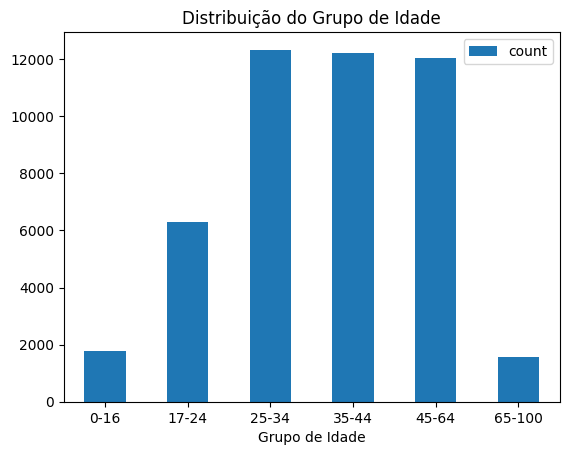

In [223]:

age_grouped = df.groupBy("grupo_idade").count().orderBy("grupo_idade").toPandas()

age_grouped.plot(x="grupo_idade", y="count", kind="bar")
plt.xlabel("Grupo de Idade")

plt.xticks(rotation=0)
plt.title("Distribuição do Grupo de Idade")
plt.show()


### <a id='toc1_3_7_'></a>[Balanceamento dos Dados](#toc0_)

<Axes: xlabel='mortos'>

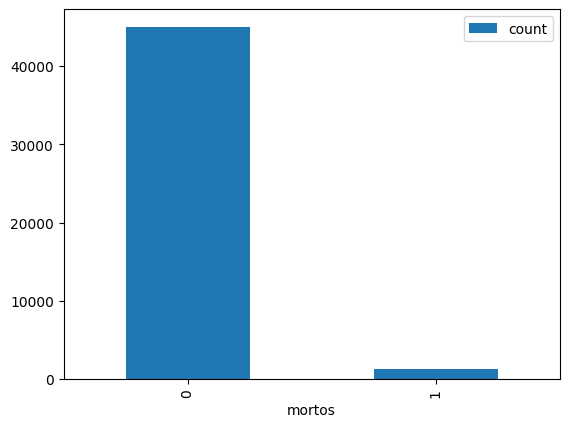

In [224]:

pandas_df = df.groupBy("mortos").count().toPandas()
pandas_df.plot(x="mortos", y="count", kind="bar")

In [225]:
majority_count = pandas_df[pandas_df['mortos'] == '0']["count"].values[0]
minority_count = pandas_df[pandas_df['mortos'] == '1']["count"].values[0]

print("O tamanho da amostra minoritária é: {}".format(minority_count))
print("O tamanho da amostra majoritária é: {}".format(majority_count))

O tamanho da amostra minoritária é: 1217
O tamanho da amostra majoritária é: 45028


In [226]:
minority_sample = df.filter(col("mortos") == '1')
majority_sample = df.filter(col("mortos") == '0')

ratio = majority_count / minority_count

minority_sample = minority_sample.sample(withReplacement=True, fraction=ratio, seed=1)
df = minority_sample.unionAll(majority_sample)



<Axes: xlabel='mortos'>

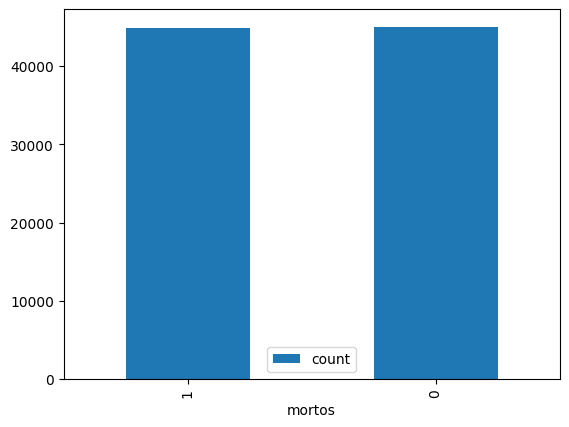

In [227]:

pandas_df = df.groupBy("mortos").count().toPandas()
pandas_df.plot(x="mortos", y="count", kind="bar")

## <a id='toc1_4_'></a>[Criando datasets](#toc0_)

Vamos criar dois datasets que serão utilizados em dois experimentos, o primeiro será o controle que não vamos remover os outliers, já o outro será removendo o outliers.

In [228]:
df = df.withColumn("mortos", col("mortos").cast(IntegerType()))

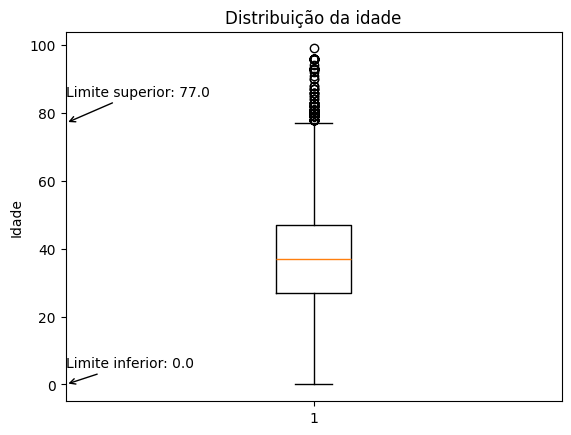

In [229]:

pandas_df = df.select("idade").toPandas()

boxplot = plt.boxplot(pandas_df["idade"])
plt.ylabel("Idade")
plt.title("Distribuição da idade")

whiskers = [item.get_ydata() for item in boxplot['whiskers']]
plt.annotate("Limite inferior: {}".format(whiskers[0][1]), xy=(0.5, whiskers[0][1]), xytext=(0.5, whiskers[0][1] + 5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate("Limite superior: {}".format(whiskers[1][1]), xy=(0.5, whiskers[1][1]), xytext=(0.5, whiskers[1][1] + 8),
             arrowprops=dict(facecolor='black', arrowstyle="->"))


plt.show()


In [230]:
df_outliers_removed = df.filter((col('idade') >= 0) & (col('idade') <= 77))

Se notarmos podemos identificar que os outliers acontecem após **77 anos**, dessa forma vamos criar um dataset sem outliers.

### <a id='toc1_4_1_'></a>[Seleção de Features](#toc0_)

In [231]:

COLUNMS = ['uf', 'periodo', 'clima','tipo_pista', 'tipo_veiculo', 'grupo_idade', 'sexo', 'feriado', 'mortos']
dataset_v1 = df.select(COLUNMS)
dataset_v2 = df_outliers_removed.select(COLUNMS)


### <a id='toc1_4_2_'></a>[Persistindo Datasets](#toc0_)

In [232]:
dataset_v1.write.mode('overwrite').parquet(f"{OUTPUT_PATH}/dataset_v1.parquet")
dataset_v2.write.mode('overwrite').parquet(f"{OUTPUT_PATH}/dataset_v2.parquet")


24/03/15 14:28:53 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
